The focus of the previous examples in this course was on classification problems. However, regression problems are also quite common in practice and it will be what we will try to explore in this application.

## Problem Setup

The dataset that we will be using is the Kaggle dataset called ["House Sales in King County, USA"](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction). As far as I know, this was not used in a Kaggle competition. However, it is a quite popular dataset on Kaggle. The description reads:

> This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015.
>
> It's a great dataset for evaluating simple regression models.

This means that the dataset is a snapshot of house prices in King County, USA, between May 2014 and May 2015. The task, then, is quite straightforward: given a set of features, we want to predict the price of a house.


## Dataset

Unfortunately, the dataset does not have a detailed description of the variables. However, in the comment section, some users found references with variable descriptions. The variables in the dataset should be as follows:

| Variable | Description |
|:----|:----------------|
| id | Unique ID for each home sold |
| date | Date of the home sale |
| price | Price of each home sold |
| bedrooms | Number of bedrooms |
| bathrooms | Number of bathrooms, where .5 accounts for a room with a toilet but no shower |
| sqft_living | Square footage of the apartments' interior living space |
| sqft_lot | Square footage of the land space |
| floors | Number of floors |
| waterfront | A dummy variable for whether the apartment was overlooking the waterfront or not |
| view | An index from 0 to 4 of how good the view of the property was |
| condition | An index from 1 to 5 on the condition of the apartment |
| grade | An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design. |
| sqft_above | The square footage of the interior housing space that is above ground level |
| sqft_basement | The square footage of the interior housing space that is below ground level |
| yr_built | The year the house was initially built |
| yr_renovated | The year of the house’s last renovation |
| zipcode | What zipcode area the house is in |
| lat | Lattitude |
| long | Longitude |
| sqft_living15 | The square footage of interior housing living space for the nearest 15 neighbors |
| sqft_lot15 | The square footage of the land lots of the nearest 15 neighbors |


## Putting the Problem into the Context of the Course

The problem of predicting house prices is a **regression problem** which belongs to the type of **supervised learning** problems. We will use the same tools that we have used in the previous examples to solve this problem. The main difference is that we will be using regression models instead of classification models.


## Setting up the Environment

We will start by setting up the environment by importing the necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Let's download the dataset automatically, unzip it, and place it in a folder called `data` if you haven't done so already

In [2]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import os.path

# Check if the file exists
if not os.path.isfile('data/kc_house_data.csv'):

    print('Downloading dataset...')

    # Define the dataset to be downloaded
    zipurl = 'https://www.kaggle.com/api/v1/datasets/download/harlfoxem/housesalesprediction'

    # Download and unzip the dataset in the data folder
    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall('data')

    print('DONE!')

else:

    print('Dataset already downloaded!')

Dataset already downloaded!


Then, we can load the data into a DataFrame using the `read_csv` function from the `pandas` library

In [3]:
df = pd.read_csv('data/kc_house_data.csv')

Let's also download some precomputed models that we will use later on

In [4]:
for file_name in ['reg_nn.joblib', 'reg_nn_cv.joblib', 'reg_xgb_cv.joblib', 'reg_rf_cv.joblib.zip']:

    if not os.path.isfile(file_name):

        print(f'Downloading {file_name}...')

        # Generate the download link
        url = f'https://github.com/jmarbet/data-science-course/raw/main/notebooks/{file_name}'

        if file_name.endswith('.zip'):

            # Download and unzip the file
            with urlopen(url) as zipresp:
                with ZipFile(BytesIO(zipresp.read())) as zfile:
                    zfile.extractall('')

        else:

            # Download the file
            with urlopen(url) as response, open(file_name, 'wb') as out_file:
                data = response.read()
                out_file.write(data)

        print('DONE!')

    else:

        print(f'{file_name} already downloaded!')

reg_nn.joblib already downloaded!
reg_nn_cv.joblib already downloaded!
reg_xgb_cv.joblib already downloaded!
reg_rf_cv.joblib.zip already downloaded!


## Data Exploration

As with any new dataset, we first need to familiarize ourselves with the data. We will start by looking at the first few rows of the dataset.

In [5]:
df.head(4).T # Transpose the dataframe for readability

,0,1,2,3
id,7129300520,6414100192,5631500400,2487200875
date,20141013T000000,20141209T000000,20150225T000000,20141209T000000
price,221900.0,538000.0,180000.0,604000.0
bedrooms,3,3,2,4
bathrooms,1.0,2.25,1.0,3.0
sqft_living,1180,2570,770,1960
sqft_lot,5650,7242,10000,5000
floors,1.0,2.0,1.0,1.0
waterfront,0,0,0,0
view,0,0,0,0


and for reference, we can also run `df.info()` again to see the data types of the variables

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

What immediately stands out is that the `date` column does not seem to be a proper datetime object. So, let's fix that

In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df.head().T

,0,1,2,3,4
id,7129300520,6414100192,5631500400,2487200875,1954400510
date,2014-10-13 00:00:00,2014-12-09 00:00:00,2015-02-25 00:00:00,2014-12-09 00:00:00,2015-02-18 00:00:00
price,221900.0,538000.0,180000.0,604000.0,510000.0
bedrooms,3,3,2,4,3
bathrooms,1.0,2.25,1.0,3.0,2.0
sqft_living,1180,2570,770,1960,1680
sqft_lot,5650,7242,10000,5000,8080
floors,1.0,2.0,1.0,1.0,1.0
waterfront,0,0,0,0,0
view,0,0,0,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21613 non-null  int64         
 1   date           21613 non-null  datetime64[ns]
 2   price          21613 non-null  float64       
 3   bedrooms       21613 non-null  int64         
 4   bathrooms      21613 non-null  float64       
 5   sqft_living    21613 non-null  int64         
 6   sqft_lot       21613 non-null  int64         
 7   floors         21613 non-null  float64       
 8   waterfront     21613 non-null  int64         
 9   view           21613 non-null  int64         
 10  condition      21613 non-null  int64         
 11  grade          21613 non-null  int64         
 12  sqft_above     21613 non-null  int64         
 13  sqft_basement  21613 non-null  int64         
 14  yr_built       21613 non-null  int64         
 15  yr_renovated   2161

Much better! Note how the variable type changed for `date`. On the topic of variable types, it seems surprising that `bathrooms` and `floors` are of type `float64`. Let's check if there is anything unusual about these variables

In [10]:
df['bathrooms'].value_counts()

bathrooms
2.50    5380
1.00    3852
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: count, dtype: int64

In [11]:
df['floors'].value_counts()

floors
1.0    10680
2.0     8241
1.5     1910
3.0      613
2.5      161
3.5        8
Name: count, dtype: int64

It seems that the number of bathrooms and floors is not always an integer. This is a bit surprising, but a possible interpretation is that in the case of bathrooms, smaller bathrooms with e.g., only a toilet and a sink are counted as 0.5 bathrooms, while a full bathroom would also need a shower or a bathtub. The same logic could apply to floors, where a split-level house could have, e.g., 1.5 floors. This is just a guess, but it seems plausible.

Note also that there do not seem to be any missing values, at least none were encoded as such. Now, let's look at the summary statistics of the dataset

In [12]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
id,21613.0,4580301520.864988,1000102.0,2123049194.0,3904930410.0,7308900445.0,9900000190.0,2876565571.312049
date,21613,2014-10-29 04:38:01.959931648,2014-05-02 00:00:00,2014-07-22 00:00:00,2014-10-16 00:00:00,2015-02-17 00:00:00,2015-05-27 00:00:00,NaN
price,21613.0,540088.141767,75000.0,321950.0,450000.0,645000.0,7700000.0,367127.196483
bedrooms,21613.0,3.370842,0.0,3.0,3.0,4.0,33.0,0.930062
bathrooms,21613.0,2.114757,0.0,1.75,2.25,2.5,8.0,0.770163
sqft_living,21613.0,2079.899736,290.0,1427.0,1910.0,2550.0,13540.0,918.440897
sqft_lot,21613.0,15106.967566,520.0,5040.0,7618.0,10688.0,1651359.0,41420.511515
floors,21613.0,1.494309,1.0,1.0,1.5,2.0,3.5,0.539989
waterfront,21613.0,0.007542,0.0,0.0,0.0,0.0,1.0,0.086517
view,21613.0,0.234303,0.0,0.0,0.0,0.0,4.0,0.766318


Let's have a look at the pair plot of some of the quantitative variables

/opt/anaconda3/envs/datascience_course_cemfi_dev/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


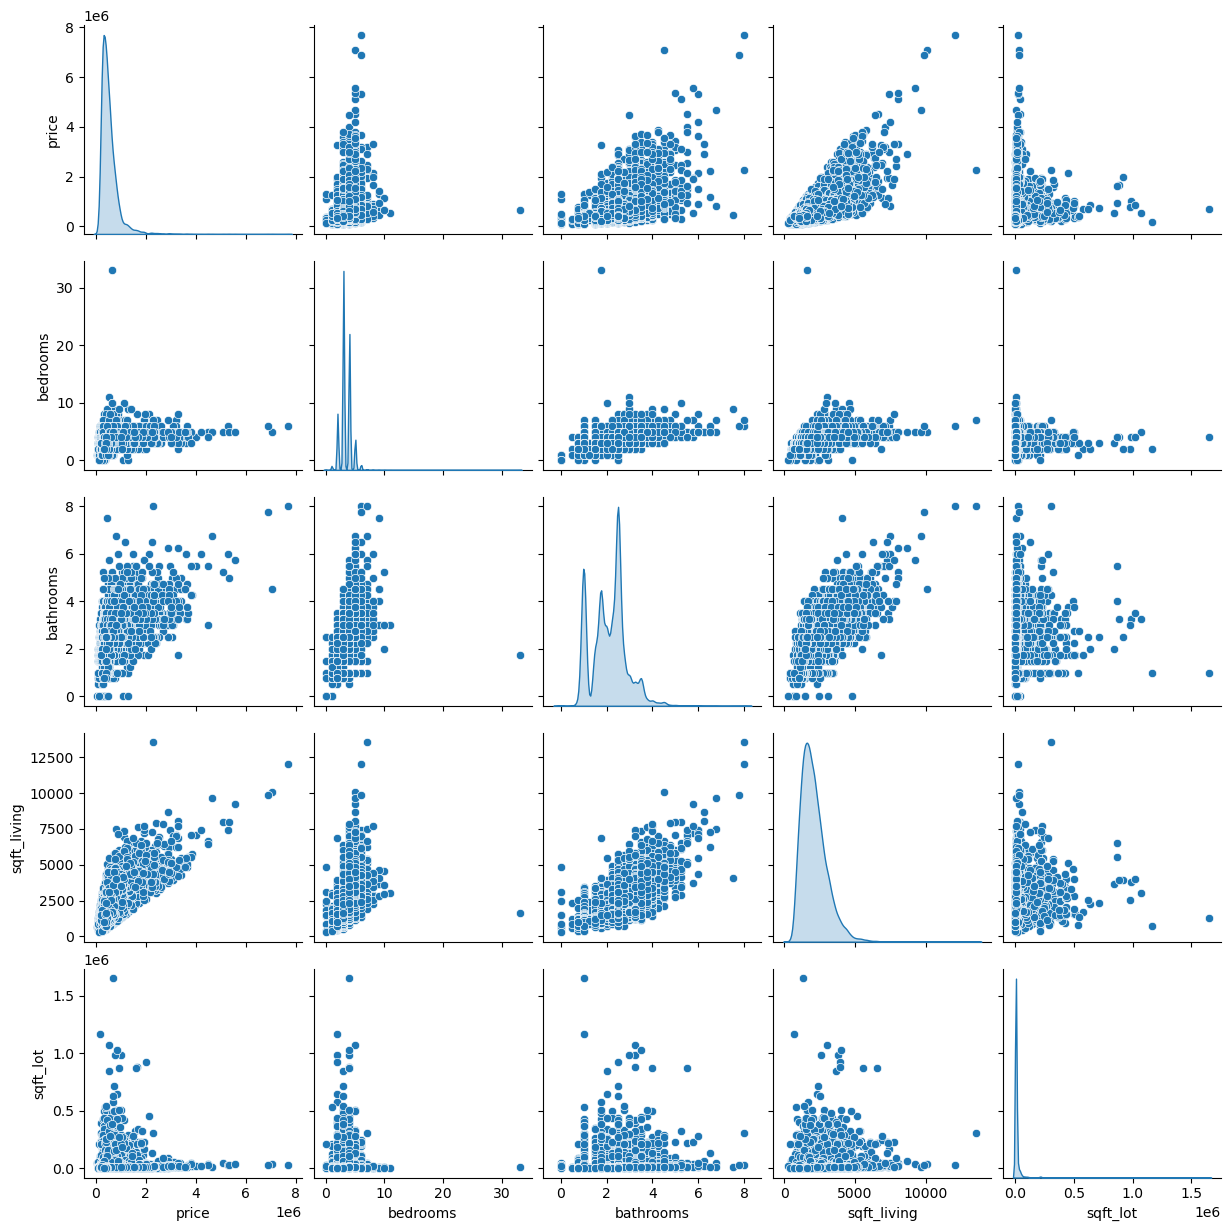

In [13]:
sns.pairplot(df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']], diag_kind='kde')

Unsurprisingly, there seems to be a positive correlation between the square footage of the living area (or number of bedrooms, or number of bathrooms) and the price of a house. However, there does not seem to be such a relationship between the square footage of the lot and the price. This is more surprising given that land prices can be very high in some areas. However, if these "houses" include many apartments (that do not include the land they are built on), this could explain the lack of a relationship. There also seems to be one house with more than 30 bedrooms. This seems a bit unusual, so let's have a closer look

In [14]:
df.query('bedrooms > 30').T

,15870
id,2402100895
date,2014-06-25 00:00:00
price,640000.0
bedrooms,33
bathrooms,1.75
sqft_living,1620
sqft_lot,6000
floors,1.0
waterfront,0
view,0


What a bargain! A house with 33 bedrooms for only $640000! However, it just has 1.75 bathrooms. It's maybe not that good of a deal after all. Considering that 1040 square feet corresponds to around 96 m^2. This seems like an error in the data. We will remove this observation from the dataset

In [15]:
df = df.query('bedrooms < 30')

We could also look at the distribution of the number of bedrooms and floors and how if affects prices

<Axes: xlabel='bedrooms', ylabel='price'>

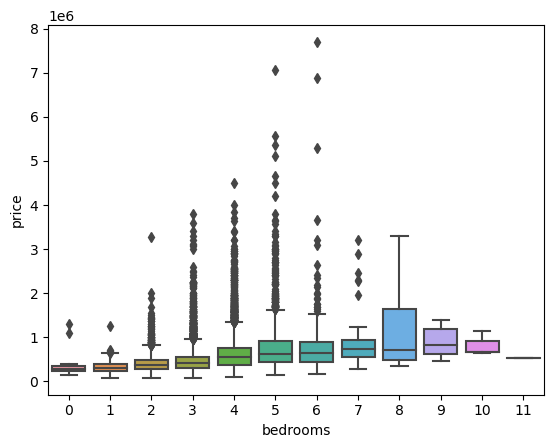

In [16]:
sns.boxplot(x=df['bedrooms'],y=df['price'])

<Axes: xlabel='floors', ylabel='price'>

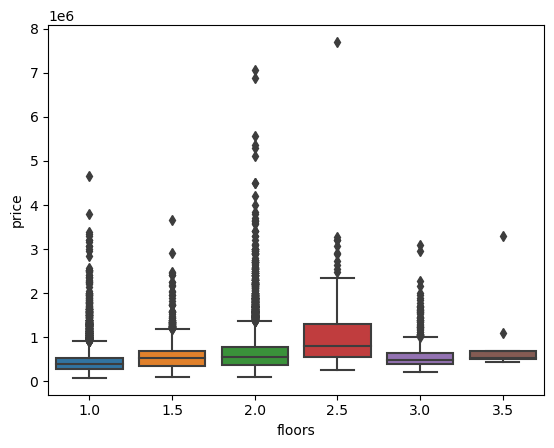

In [17]:
sns.boxplot(x=df['floors'],y=df['price'])

There seems to be great variability in the prices for a given number of bedrooms or floors.

Interestingly, we also have latitudinal and longitudinal information. We can use this to plot the houses on a map. Let's do that

In [18]:
import folium
from folium.plugins import HeatMap

# Initalize the map
m = folium.Map(location=[47.5112, -122.257])

# Create Layers and add them to the map
layer_heat_map = folium.FeatureGroup(name='Heat Map').add_to(m)
layer_most_expensive = folium.FeatureGroup(name='10 Most Expensive Houses').add_to(m)
folium.LayerControl().add_to(m)

# Add a heatmap to a layer
data = df[['lat', 'long', 'price']].groupby(['lat','long']).mean().reset_index().values.tolist() # Note for latitudes and longitudes that show up multiple times, we take the mean()
HeatMap(data, radius=8).add_to(layer_heat_map)

# Add the 10 most expensive houses to a layer
df_most_expensive_houses = df.sort_values(by=['price'], ascending=False).head(10)
for indice, row in df_most_expensive_houses.iterrows():
    folium.Marker(
        location=[row["lat"], row["long"]],
        popup=f"Price: {row['price']}",
        icon=folium.map.Icon(color='red')
    ).add_to(layer_most_expensive)

m

The 10 most expensive houses seem to be close to the waterfront and looking at the actual data, we can see that about half of them are indeed overlooking the waterfront

In [19]:
df_most_expensive_houses['waterfront']

7252    0
3914    1
9254    0
4411    0
1448    0
1315    1
1164    1
8092    1
2626    1
8638    0
Name: waterfront, dtype: int64

The heatmap also shows that the most expensive houses are located in the north-western part of the county, in or near Seattle.

Finally, let's look at the distribution of some of the discrete variables in the dataset

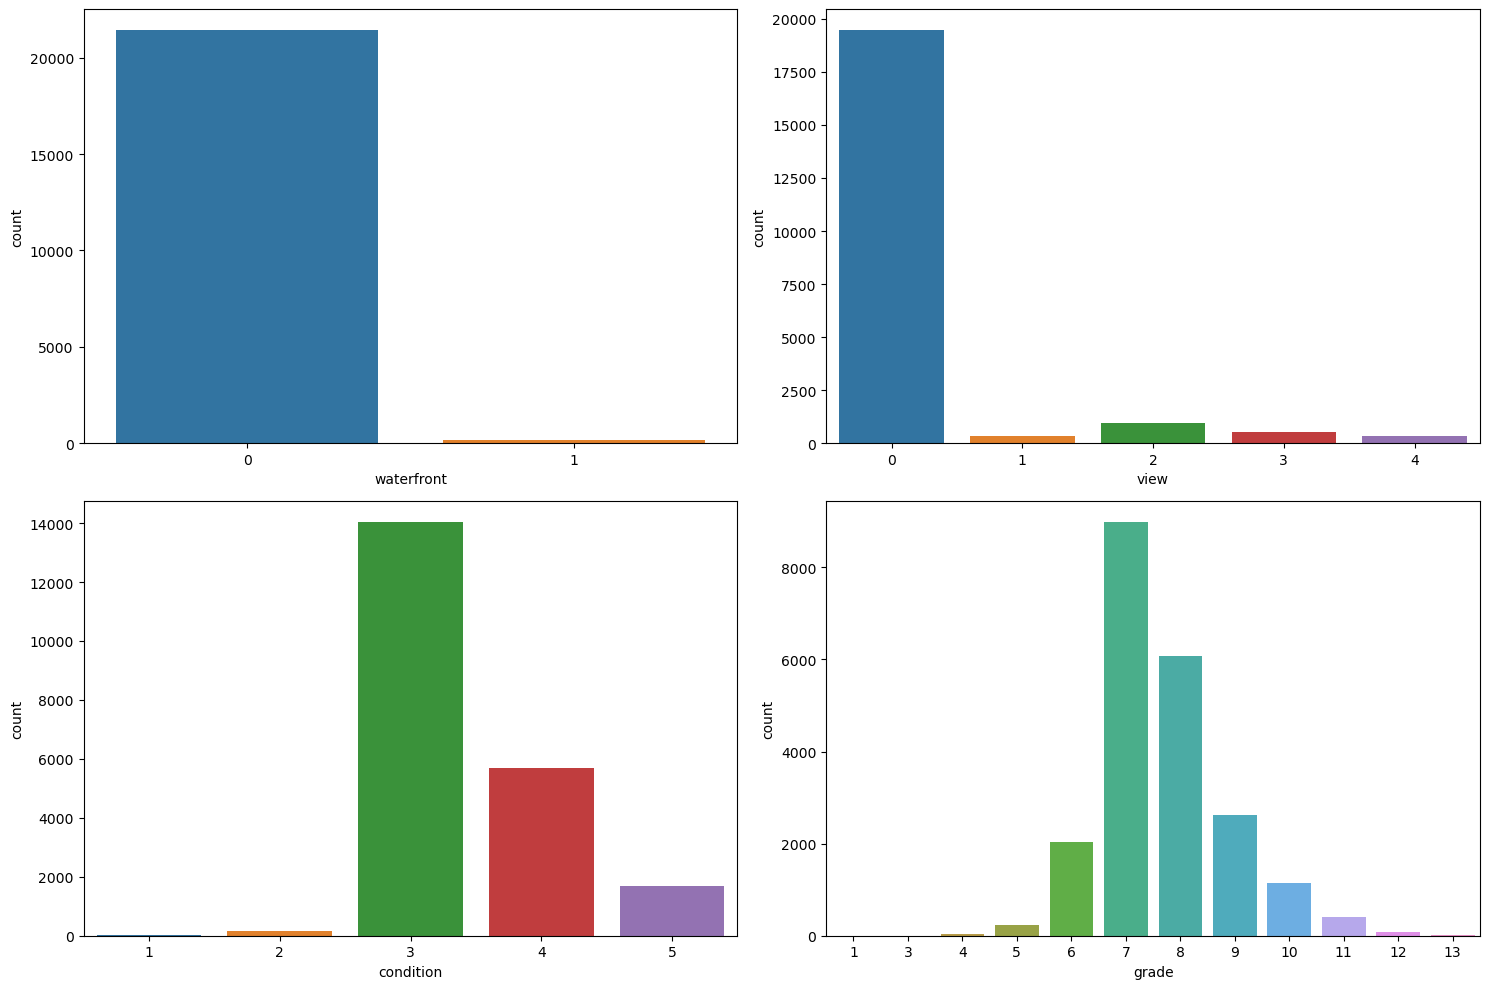

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
variables = ['waterfront', 'view', 'condition', 'grade']

for var, ax in zip(variables, axes.flatten()):
    sns.countplot(x=var, data=df, ax=ax)

plt.tight_layout()

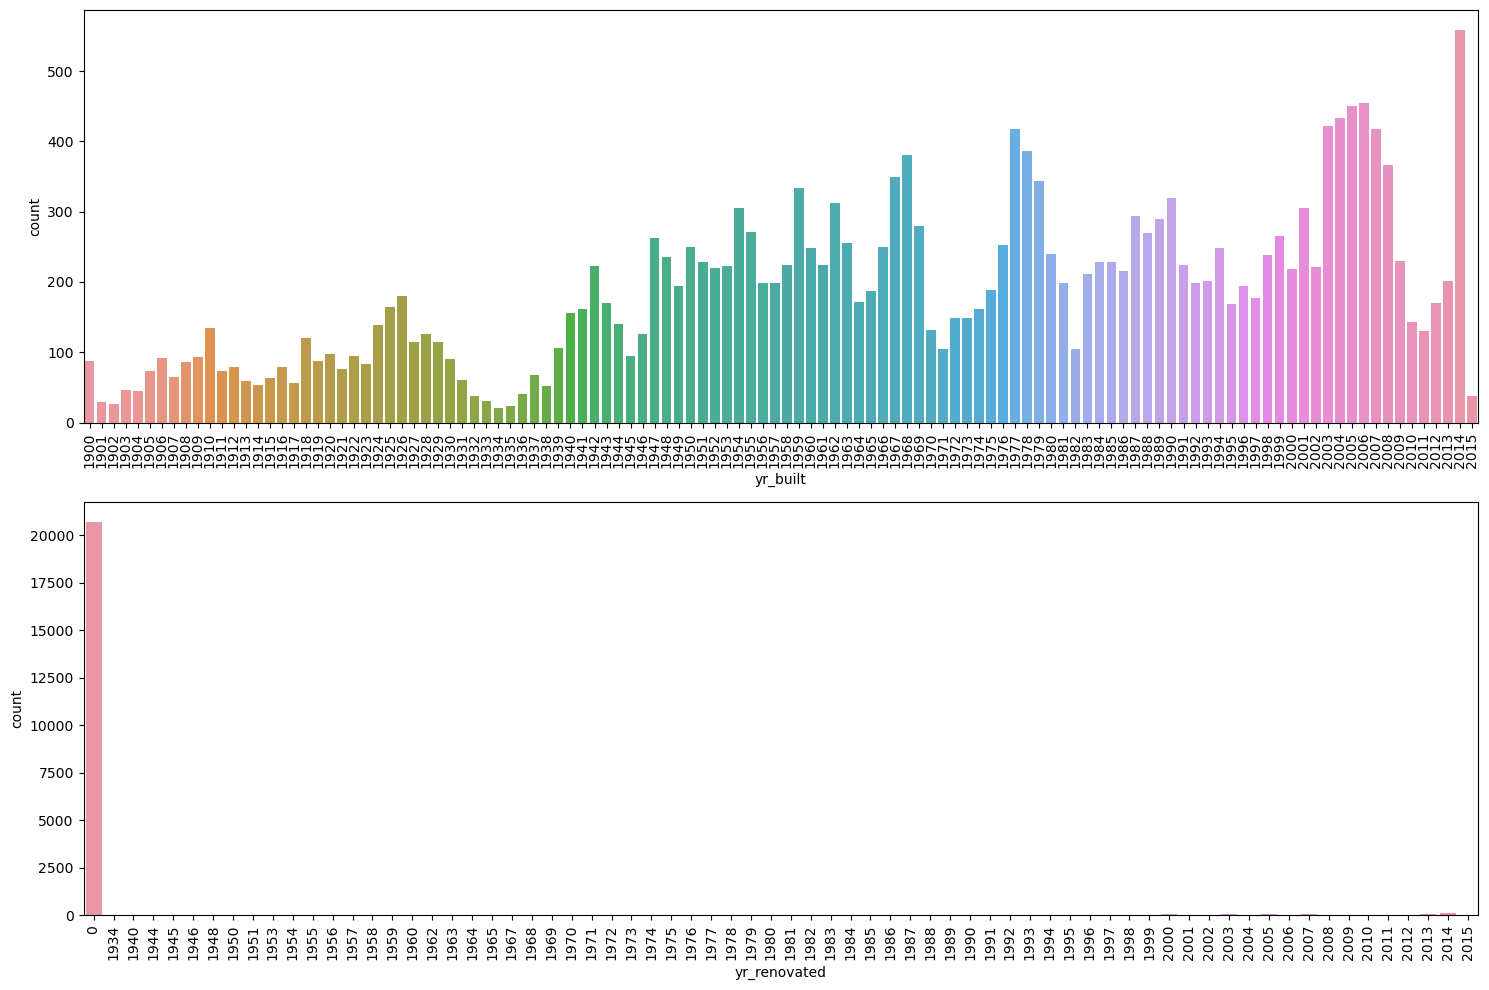

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
variables = ['yr_built', 'yr_renovated']

for var, ax in zip(variables, axes.flatten()):
    sns.countplot(x=var, data=df, ax=ax)

for ax in axes.flatten():
    if ax.get_xlabel() in ('yr_built', 'yr_renovated'):
        ax.tick_params(axis='x', labelrotation=90)

plt.tight_layout()

There seems to be some cyclicality in `yr_built`. We could probably infer housing booms and busts if we analyze it carefully. `yr_renovated` seems to have a lot of zeros, which could mean that many houses have never been renovated. Let's check what's going on here

In [22]:
df['yr_renovated'].value_counts()

yr_renovated
0       20698
2014       91
2013       37
2003       36
2005       35
        ...  
1951        1
1959        1
1948        1
1954        1
1944        1
Name: count, Length: 70, dtype: int64

Indeed, almost all of the houses seem to have a zero. However, some houses have values different from zero, so it might indeed be the case that houses with a value of zero have never been renovated. We could also check if the year of renovation is after the year the house was built

In [23]:
df.query('yr_renovated != 0 and yr_renovated < yr_built')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


With this command, we selected all observations where `yr_renovated` is different from zero and `yr_renovated < yr_built`. Since there were no rows selected, there do not seem to be any errors in the dataset in this respect.

Another thing we can check is whether there are errors in the square footage variables. For example, we could check if the sum of `sqft_above` and `sqft_basement` is equal to `sqft_living`

In [24]:
df.query('sqft_above + sqft_basement != sqft_living')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


This indeed seems to be correct for all observations. 

We haven't looked at the square footage of the 15 nearest neighbors yet. Let's check how it relates to price and the square footage of the house itself

/opt/anaconda3/envs/datascience_course_cemfi_dev/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


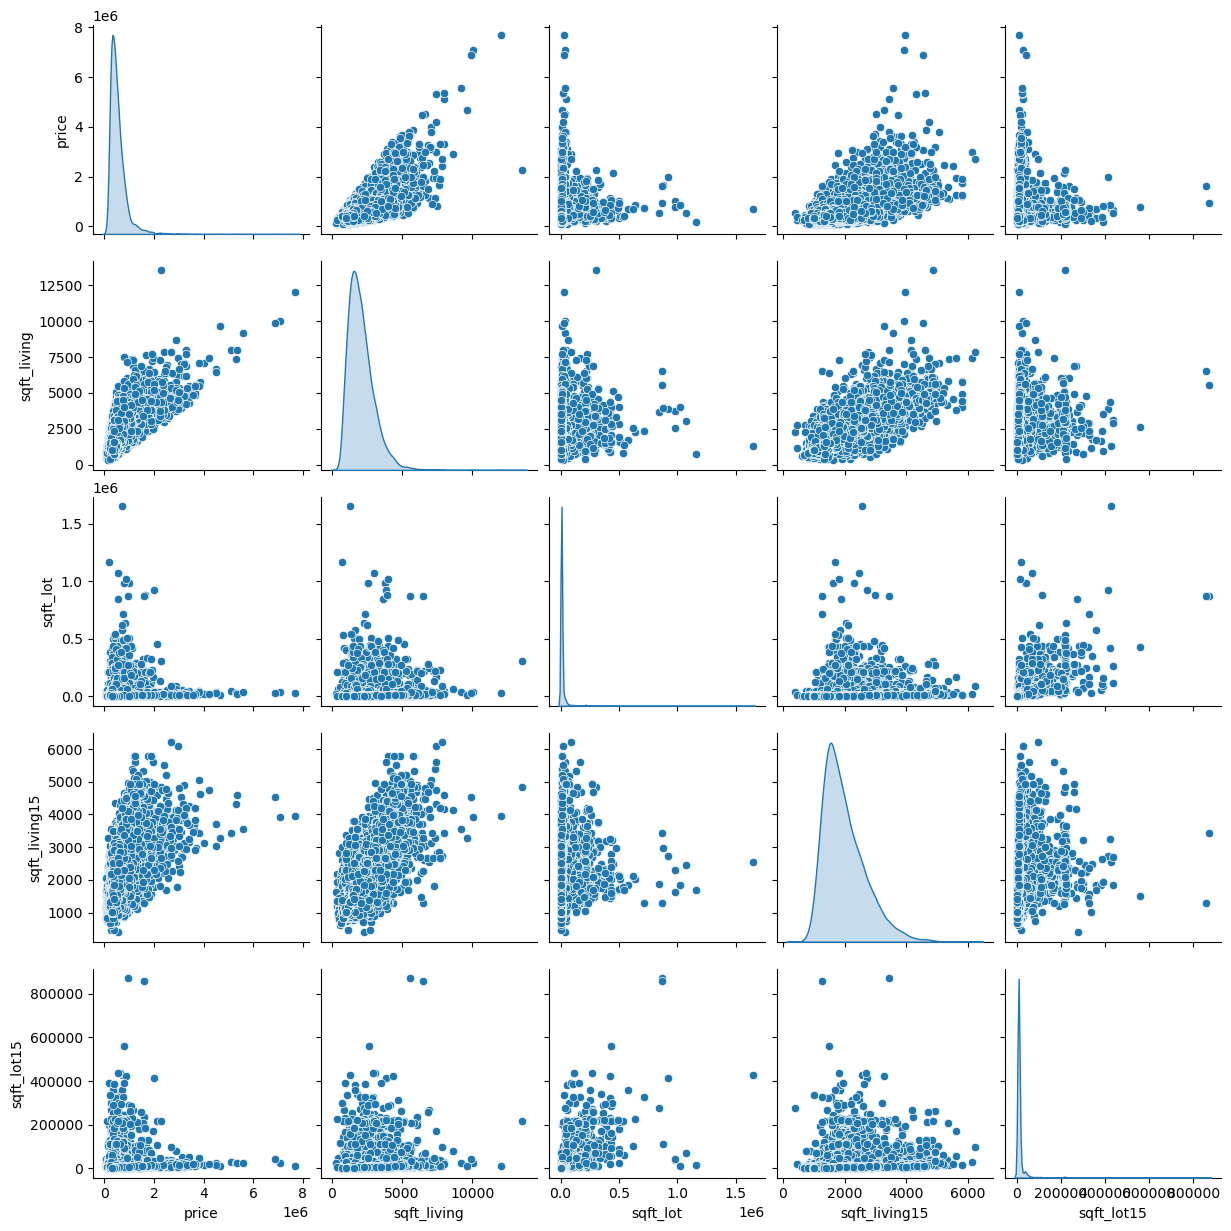

In [25]:
sns.pairplot(df[['price', 'sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15']], diag_kind='kde')

There seems to be a positive relationship between the square footage of the living area of the house and the square footage of the living area of the 15 nearest neighbors. There also seems to be a positive relationship with price. This likely just reflects the fact that neighborhoods tend to have houses of similar sizes and prices.

Finally, let's look at the distribution of the zip codes in the dataset

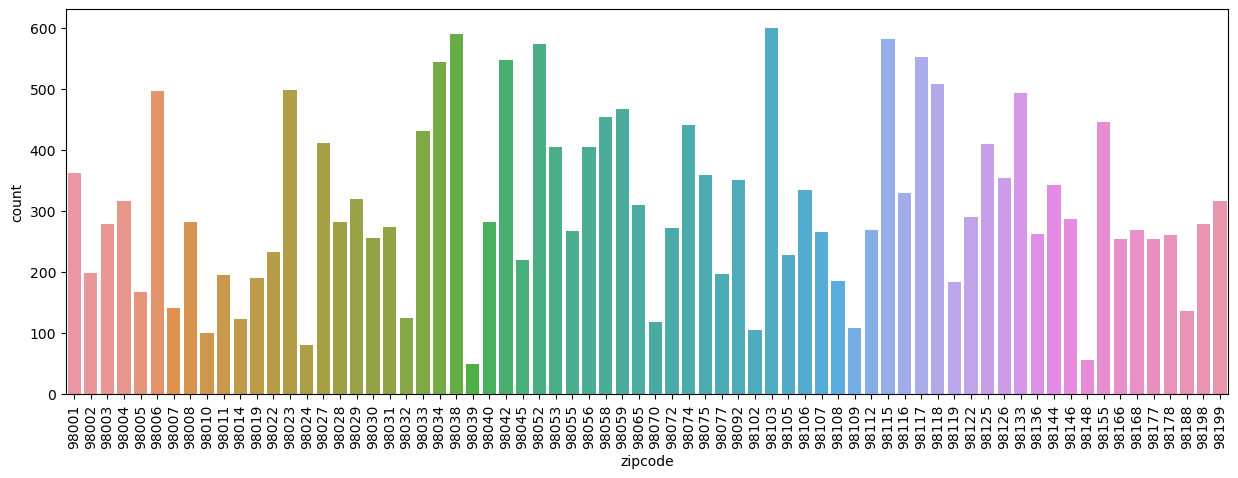

In [26]:
plt.figure(figsize=(15, 5))
sns.countplot(x='zipcode', data=df)
plt.xticks(rotation=90)
plt.show()

This likely doesn't tell us much, but it's interesting to see that some zip codes are much more common than others. Finally, we can again look at the correlation between variables in our dataset

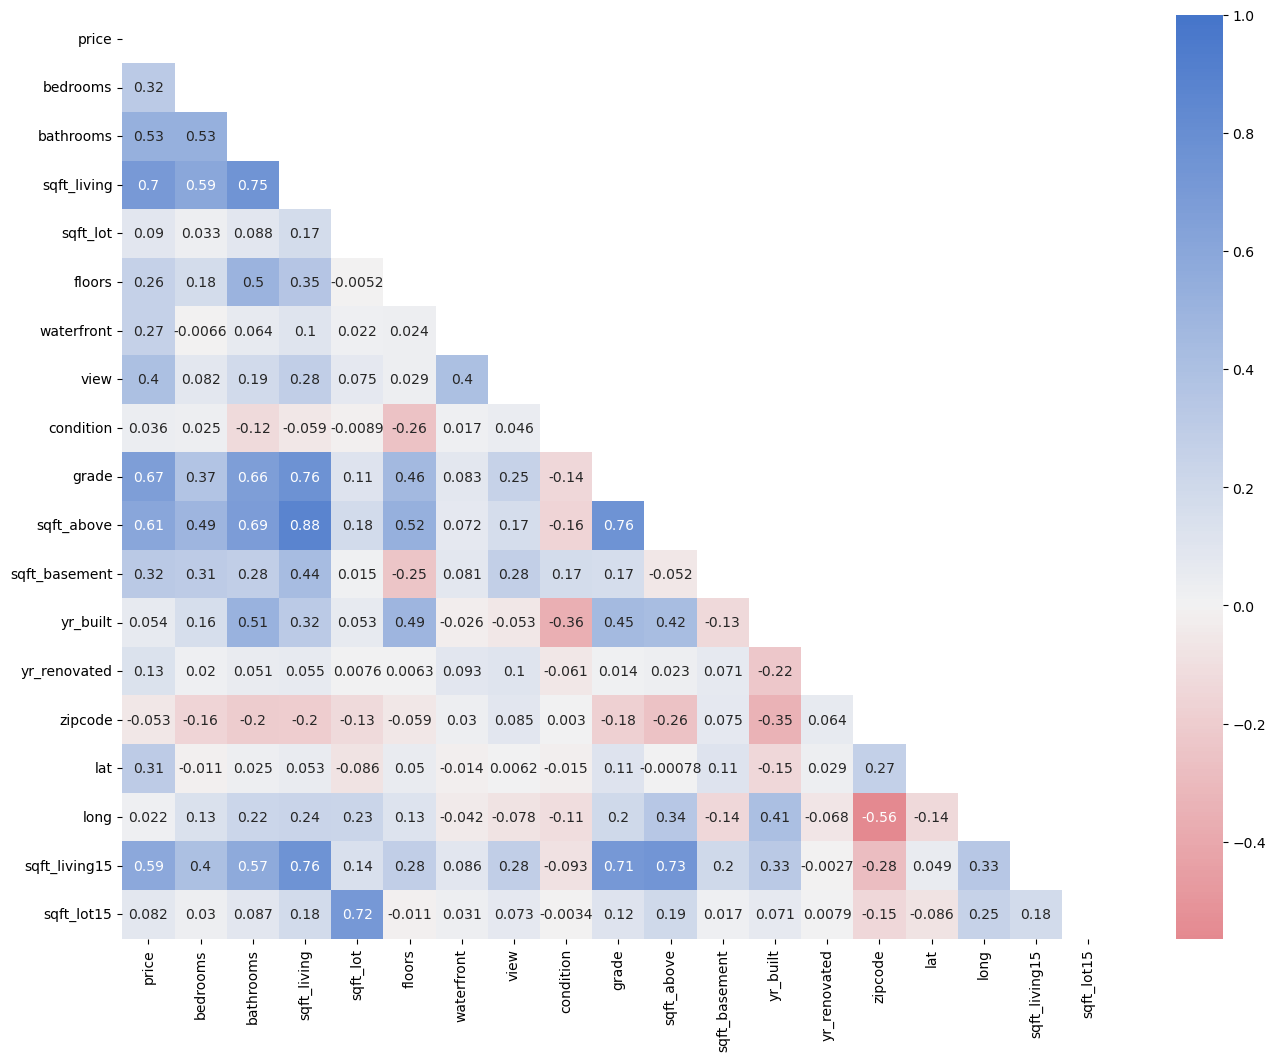

In [27]:
f, ax = plt.subplots(figsize=(16, 12))
corr = df.drop(['id', 'date'], axis=1).corr()
cmap = sns.diverging_palette(10, 255, as_cmap=True) # Create a color map
mask = np.triu(np.ones_like(corr, dtype=bool)) # Create a mask to only show the lower triangle of the matrix
sns.heatmap(corr, cmap=cmap, annot=True, vmax=1, center=0, mask=mask) # Create a heatmap of the correlation matrix (Note: vmax=1 makes sure that the color map goes up to 1 and center=0 are used to center the color map at 0)
plt.show()

## Implementation of House Price Prediction Models

We have explored our dataset and are now ready to implement machine learning algorithms for house price prediction. Let's start by importing the required libraries

In [28]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import dump, load

### Data Preprocessing

The dataset seems to be pretty clean already. Let's check again the number of missing values

In [29]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21612 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21612 non-null  int64         
 1   date           21612 non-null  datetime64[ns]
 2   price          21612 non-null  float64       
 3   bedrooms       21612 non-null  int64         
 4   bathrooms      21612 non-null  float64       
 5   sqft_living    21612 non-null  int64         
 6   sqft_lot       21612 non-null  int64         
 7   floors         21612 non-null  float64       
 8   waterfront     21612 non-null  int64         
 9   view           21612 non-null  int64         
 10  condition      21612 non-null  int64         
 11  grade          21612 non-null  int64         
 12  sqft_above     21612 non-null  int64         
 13  sqft_basement  21612 non-null  int64         
 14  yr_built       21612 non-null  int64         
 15  yr_renovated   21612 non

There don't seem to be any missing values. However, we could still check for duplicates

In [31]:
df.duplicated().sum()

0

There also don't seem to be any duplicates.

There are some variables such as `id`, `zipcode`, `lat` and `long` which likely don't provide very useful information given the other variables in the dataset. We will drop these variables

In [32]:
df = df.drop(['id', 'zipcode', 'lat', 'long'], axis=1)
df.head().T

,0,1,2,3,4
date,2014-10-13 00:00:00,2014-12-09 00:00:00,2015-02-25 00:00:00,2014-12-09 00:00:00,2015-02-18 00:00:00
price,221900.0,538000.0,180000.0,604000.0,510000.0
bedrooms,3,3,2,4,3
bathrooms,1.0,2.25,1.0,3.0,2.0
sqft_living,1180,2570,770,1960,1680
sqft_lot,5650,7242,10000,5000,8080
floors,1.0,2.0,1.0,1.0,1.0
waterfront,0,0,0,0,0
view,0,0,0,0,0
condition,3,3,3,5,3


#### Binning & Encoding {-}

Furthermore, we will need to convert the `date` variable into something that can be used in a machine-learning model. We will extract the year and month from the date and drop the original `date` variable

In [33]:
df['year_sale'] = pd.DatetimeIndex(df['date']).year
df['month_sale'] = pd.DatetimeIndex(df['date']).month

Furthermore, we can convert `yr_built` and `yr_renovated` into the age of the house and the number of years since the last renovation

In [34]:
df['age'] = df['year_sale'] - df['yr_built']
df['years_since_renovation'] = df['year_sale'] - np.maximum(df['yr_built'], df['yr_renovated'])

If the house has never been renovated, `years_since_renovation` will be equal to the age of the house. We can drop the original `yr_built`, `yr_renovated`, and `date` variables

In [35]:
df = df.drop(['yr_built', 'yr_renovated', 'date'], axis=1)

Let's check the summary statistics of the dataset again

In [36]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,21612.0,540083.518786,367135.061269,75000.0,321837.50,450000.00,645000.00,7700000.0
bedrooms,21612.0,3.369471,0.907982,0.0,3.00,3.00,4.00,11.0
bathrooms,21612.0,2.114774,0.770177,0.0,1.75,2.25,2.50,8.0
sqft_living,21612.0,2079.921016,918.456818,290.0,1426.50,1910.00,2550.00,13540.0
sqft_lot,21612.0,15107.388951,41421.423497,520.0,5040.00,7619.00,10688.25,1651359.0
floors,21612.0,1.494332,0.539991,1.0,1.00,1.50,2.00,3.5
waterfront,21612.0,0.007542,0.086519,0.0,0.00,0.00,0.00,1.0
view,21612.0,0.234314,0.766334,0.0,0.00,0.00,0.00,4.0
condition,21612.0,3.409356,0.650668,1.0,3.00,3.00,4.00,5.0
grade,21612.0,7.656904,1.175477,1.0,7.00,7.00,8.00,13.0


Finally, we need to take care of the categorical variables in the dataset. We will use one-hot (aka ‘one-of-K’ or ‘dummy’) encoding for this purpose

In [37]:
# Define for which variables to do the one-hot encoding
categorical_variables = ['view', 'condition', 'grade']

# Initialize the encoder
encoder = OneHotEncoder(sparse_output=False)

# Apply the one-hot encoding to the desired columns
one_hot_encoded = encoder.fit_transform(df[categorical_variables])

# Convert the results to a DataFrame
df_one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['view', 'condition', 'grade']), index=df.index)

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df, df_one_hot_encoded], axis=1)

# Drop the old, unencoded columns from the old Dataframe
df_encoded = df_encoded.drop(categorical_variables, axis=1)

You can see that now we have many more dummy variables taking values zero or one in our dataset

In [38]:
df_encoded.describe().T

,count,mean,std,min,25%,50%,75%,max
price,21612.0,540083.518786,367135.061269,75000.0,321837.50,450000.00,645000.00,7700000.0
bedrooms,21612.0,3.369471,0.907982,0.0,3.00,3.00,4.00,11.0
bathrooms,21612.0,2.114774,0.770177,0.0,1.75,2.25,2.50,8.0
sqft_living,21612.0,2079.921016,918.456818,290.0,1426.50,1910.00,2550.00,13540.0
sqft_lot,21612.0,15107.388951,41421.423497,520.0,5040.00,7619.00,10688.25,1651359.0
floors,21612.0,1.494332,0.539991,1.0,1.00,1.50,2.00,3.5
waterfront,21612.0,0.007542,0.086519,0.0,0.00,0.00,0.00,1.0
sqft_above,21612.0,1788.425319,828.094487,290.0,1190.00,1560.00,2210.00,9410.0
sqft_basement,21612.0,291.495697,442.580931,0.0,0.00,0.00,560.00,4820.0
sqft_living15,21612.0,1986.582871,685.392610,399.0,1490.00,1840.00,2360.00,6210.0


Given that these categorical variables are ordinal, this might have not been strictly necessary. However, is required if you have data that is not ordinal.


#### Splitting the Data into Training and Test Sets {-}

Before we can train a machine learning model, we need to split our dataset into a training set and a test set. 

In [39]:
X = df_encoded.drop('price', axis=1) # All variables except `SeriousDlqin2yrs`
y = df_encoded[['price']] # Only SeriousDlqin2yrs

We will use 80% of the data for training and 20% for testing. Note that since our target variable is continuous, we don't need to stratify the split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### Scaling Features {-}

To improve the performance of our machine learning model, we should scale the features. We will use the `StandardScaler` and `MinMaxScaler`class from the `sklearn.preprocessing` module to scale the features. The `StandardScaler` scales each feature to have a mean of 0 and a standard deviation of 1. The `MinMaxScaler` scales each feature to a given range, usually 0 to 1.

In [41]:
def scale_features(scaler, df, col_names, only_transform=False):

    # Extract the features we want to scale
    features = df[col_names] 

    # Fit the scaler to the features and transform them
    if only_transform:
        features = scaler.transform(features.values)
    else:
        features = scaler.fit_transform(features.values)

    # Replace the original features with the scaled features
    df[col_names] = features


# Define which features to scale with the StandardScaler and MinMaxScaler
for_standard_scaler = [
    'bedrooms', 
    'bathrooms', 
    'sqft_living', 
    'sqft_lot', 
    'floors', 
    'sqft_above', 
    'sqft_basement', 
    'sqft_living15', 
    'sqft_lot15', 
    'age', 
    'years_since_renovation'
]

for_min_max_scaler = [
    'year_sale', 
    'month_sale'
]

# Apply the standard scaler (Note: we use the same mean and std for scaling the test set)
standard_scaler = StandardScaler() 
scale_features(standard_scaler, X_train, for_standard_scaler)
scale_features(standard_scaler, X_test, for_standard_scaler, only_transform=True)

# Apply the minmax scaler (Note: we use the same min and max for scaling the test set)
minmax_scaler = MinMaxScaler()
scale_features(minmax_scaler, X_train, for_min_max_scaler)
scale_features(minmax_scaler, X_test, for_min_max_scaler, only_transform=True)

# Apply standard scaler to the target variable
target_scaler = StandardScaler()
y_train = pd.DataFrame(target_scaler.fit_transform(y_train), columns=['price'])
y_test = pd.DataFrame(target_scaler.transform(y_test), columns=['price']) 

### Evaluation Criertia

We will evaluate our models based on the following criteria

- **Root Mean Squared Error (MSE)**: Square root of the mean of the squared differences between the predicted and the actual values
- **Mean Absolute Error (MAE)**: Mean of the absolute differences between the predicted and the actual values
- **R-squared (R2)**: Proportion of the variance in the dependent variable that is predictable from the independent variables

We define a function that a function that will calculate these metrics for us

In [42]:
def evaluate_model(model, X_train, y_train, X_test, y_test, label='', print_results=True):

    # Predict the target variable
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Transform the target variable back to the original scale 
    # (This makes it easier to interpret the RMSE and MAE)
    y_train_inv = target_scaler.inverse_transform(y_train)
    y_test_inv = target_scaler.inverse_transform(y_test)
    y_pred_train_inv = target_scaler.inverse_transform(y_pred_train.reshape(-1, 1))
    y_pred_test_inv = target_scaler.inverse_transform(y_pred_test.reshape(-1, 1))

    # Calculate the evaluation metrics
    rmse_train = mean_squared_error(y_train_inv, y_pred_train_inv, squared=False)
    rmse_test = mean_squared_error(y_test_inv, y_pred_test_inv, squared=False)
    mae_train = mean_absolute_error(y_train_inv, y_pred_train_inv)
    mae_test = mean_absolute_error(y_test_inv, y_pred_test_inv)
    r2_train = r2_score(y_train_inv, y_pred_train_inv)
    r2_test = r2_score(y_test_inv, y_pred_test_inv)

    # Print the evaluation metrics
    if print_results:
        print(f"--------------------------------------------------------------")
        print(f"Metrics: {label}")
        print(f"--------------------------------------------------------------")
        print(f"RMSE (Train): {rmse_train}")
        print(f"MAE (Train): {mae_train}")
        print(f"R2 (Train): {r2_train}")
        print(f"--------------------------------------------------------------")
        print(f"RMSE (Test): {rmse_test}")
        print(f"MAE (Test): {mae_test}")
        print(f"R2 (Test): {r2_test}")
        print(f"--------------------------------------------------------------")

    return rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test

### Linear Regression

We will start by training a simple linear regression model using only a few basic features

In [43]:
basic_features = ['bedrooms', 'bathrooms', 'sqft_living']
reg_lin_basic = LinearRegression().fit(X_train[basic_features], y_train)

We can evaluate the model using the function we defined earlier

In [44]:
evaluate_model(reg_lin_basic, X_train[basic_features], y_train, X_test[basic_features], y_test, label = 'Linear Regression (Basic Features)');

--------------------------------------------------------------
Metrics: Linear Regression (Basic Features)
--------------------------------------------------------------
RMSE (Train): 253683.12629128053
MAE (Train): 168994.9071419931
R2 (Train): 0.5085183567620137
--------------------------------------------------------------
RMSE (Test): 271925.6970016718
MAE (Test): 174452.3090166579
R2 (Test): 0.5073277848405491
--------------------------------------------------------------


We are not doing that badly with a RMSE of around $250000 if we take into account the minimum and maximum prices in the dataset

In [45]:
print(f'Min Price: {df["price"].min()}, Max Price: {df["price"].max()}')

Min Price: 75000.0, Max Price: 7700000.0


and the distribution of prices

(0.0, 3000000.0)

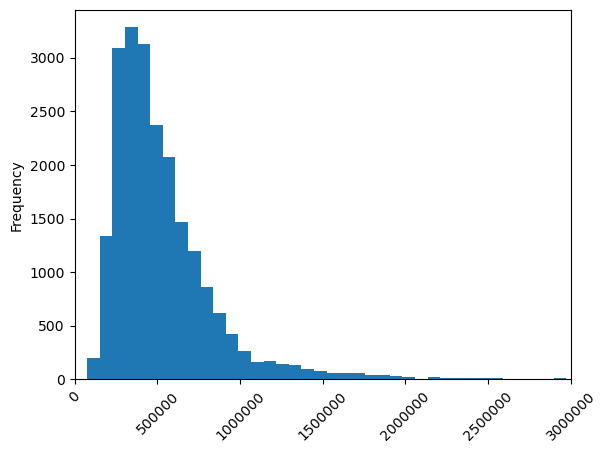

In [46]:
ax = df['price'].plot.hist(bins=100)
ax.ticklabel_format(useOffset=False,style='plain')
ax.tick_params(axis='x', labelrotation=45)
ax.set_xlim(0,3000000)

Let's now try a linear regression but with all the features

In [47]:
reg_lin = LinearRegression().fit(X_train, y_train)

We can evaluate the model using the function we defined earlier

In [48]:
evaluate_model(reg_lin, X_train, y_train, X_test, y_test, label = 'Linear Regression (All Features)');

--------------------------------------------------------------
Metrics: Linear Regression (All Features)
--------------------------------------------------------------
RMSE (Train): 203680.13271422562
MAE (Train): 133387.29115116654
R2 (Train): 0.6831735158523966
--------------------------------------------------------------
RMSE (Test): 215930.28643225055
MAE (Test): 137547.23127374452
R2 (Test): 0.6893404625153258
--------------------------------------------------------------


The performance of the model has improved. Since we have a large sample size but relatively few regressors it is unlikely to overfit. Note, however, that if we add more regressors, e.g., squared and cubed features, etc. we might run into trouble at a certain point. That's why it's important to use the train-test split to check that our model generalizes.


### LASSO Regression

One way to deal with overfitting in a linear regression is to use LASSO regression. LASSO regression is a type of linear regression that uses a penalty (or regularization) term to shrink the coefficients of the regressors towards zero. Essentially, LASSO selects a subset of features, which can help to prevent overfitting. We will use the `Lasso` class from the `sklearn.linear_model` module to train a LASSO regression model

In [49]:
reg_lasso = Lasso(alpha=0.1).fit(X_train, y_train)

We can evaluate the model using the function we defined earlier

In [50]:
evaluate_model(reg_lasso, X_train, y_train, X_test, y_test, label = 'LASSO Regression');

--------------------------------------------------------------
Metrics: LASSO Regression
--------------------------------------------------------------
RMSE (Train): 254661.31873140397
MAE (Train): 163764.59579244166
R2 (Train): 0.5047207803287292
--------------------------------------------------------------
RMSE (Test): 273446.0239203981
MAE (Test): 168730.33198849438
R2 (Test): 0.5018033587261654
--------------------------------------------------------------


This model is doing a bit worse than a standard linear regression. However, we just chose the value of the penalty term $\alpha$ arbitrarily. We can use cross-validation to find the best value of $\alpha$

In [51]:
reg_lasso_cv = LassoCV(cv=5, random_state=42).fit(X_train, y_train.values.ravel())

This command repeatedly runs 5-fold cross-validation for a LASSO regression using different values of $\alpha$. The $\alpha$ that minimizes the mean squared error is then stored in the `alpha_` attribute of the model

In [52]:
reg_lasso_cv.alpha_

0.0007018253833076978

This $\alpha$ is much smaller than our initial value. Let's see how well it does in terms of the RMSE

In [53]:
evaluate_model(reg_lasso_cv, X_train, y_train, X_test, y_test, label = 'LASSO Regression (CV)');

--------------------------------------------------------------
Metrics: LASSO Regression (CV)
--------------------------------------------------------------
RMSE (Train): 204360.76389300276
MAE (Train): 134141.73731503487
R2 (Train): 0.6810525207180653
--------------------------------------------------------------
RMSE (Test): 217146.28161042708
MAE (Test): 138085.31092628682
R2 (Test): 0.6858316989155063
--------------------------------------------------------------


It's always a good idea to use cross-validation to find the best hyperparameters for your model. For more complicated models with several hyperparameter choices, one can use `GridSearchCV` or `RandomizedSearchCV` from `sklearn` to find the hyperparameters.

We can check which coefficients the LASSO regression has shrunk to zero because of the regularization term

In [54]:
X_train.columns[np.abs(reg_lasso_cv.coef_) < 1e-12]

Index(['sqft_above', 'view_1', 'view_3', 'condition_1', 'condition_3',
       'grade_1', 'grade_3'],
      dtype='object')

Compare this to the linear regression where none of the coefficients were zero

In [55]:
X_train.columns[(np.abs(reg_lin.coef_) < 1e-12).reshape(-1)]

Index([], dtype='object')

### Decision Tree

We will now train a decision tree regressor on the data

In [56]:
reg_tree = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)

We can evaluate the model using the function we defined earlier

In [57]:
evaluate_model(reg_tree, X_train, y_train, X_test, y_test, label = 'Decision Tree');

--------------------------------------------------------------
Metrics: Decision Tree
--------------------------------------------------------------
RMSE (Train): 0.0
MAE (Train): 0.0
R2 (Train): 1.0
--------------------------------------------------------------
RMSE (Test): 276927.1448808092
MAE (Test): 163650.69442516772
R2 (Test): 0.48903797314415076
--------------------------------------------------------------


The decision tree perfectly fits the training data but does not generalize well to the test data. Why did this happen? We did not change any of the default hyperparameters of the decision tree which resulted in the decision tree overfitting, i.e., it learned the noise in the training data. We can try to reduce the depth of the tree to prevent overfitting

In [58]:
reg_tree = DecisionTreeRegressor(max_depth=10, random_state=42).fit(X_train, y_train)
evaluate_model(reg_tree, X_train, y_train, X_test, y_test, label = 'Decision Tree');

--------------------------------------------------------------
Metrics: Decision Tree
--------------------------------------------------------------
RMSE (Train): 151229.68262754745
MAE (Train): 104245.46532488744
R2 (Train): 0.8253380836313531
--------------------------------------------------------------
RMSE (Test): 242624.93510350658
MAE (Test): 139455.8139319333
R2 (Test): 0.6077811751936795
--------------------------------------------------------------


This seems to have improved the performance of the model. However, we need a more rigorous way to find the best hyperparameters. One such way is to use grid search, which tries many different hyperparameter values. We, then, combine this with cross-validation to find the best hyperparameters for the decision tree. `GridSearchCV` from the `sklearn` package does exactly that

In [59]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10]
}

reg_tree_cv = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5).fit(X_train, y_train)

Note that `param_grid` is a dictionary where the keys are the hyperparameters of the decision tree and the values are lists of the values we want to try. The best hyperparameters are stored in the `best_params_` attribute of the model

In [60]:
reg_tree_cv.best_params_

{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 15}

We can then evaluate the model using the best hyperparameters

In [61]:
evaluate_model(reg_tree_cv, X_train, y_train, X_test, y_test, label = 'Decision Tree (CV)');

--------------------------------------------------------------
Metrics: Decision Tree (CV)
--------------------------------------------------------------
RMSE (Train): 165756.35013566245
MAE (Train): 111454.50933401058
R2 (Train): 0.7901714932986897
--------------------------------------------------------------
RMSE (Test): 233527.64612876996
MAE (Test): 137387.4802938534
R2 (Test): 0.6366424628160059
--------------------------------------------------------------


Note that using `reg_tree_cv` as the model to be evaluated uses automatically the best estimator. Alternatively, we could also use `best_estimator_` attribute in `evaluate_model`

In [62]:
reg_tree_cv.best_estimator_

DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=15,
                      random_state=42)

### Random Forest

We will now train a random forest regressor on the data

In [63]:
reg_rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)

/opt/anaconda3/envs/datascience_course_cemfi_dev/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


We can evaluate the model using the function we defined earlier

In [64]:
evaluate_model(reg_rf, X_train, y_train, X_test, y_test, label = 'Random Forest');

--------------------------------------------------------------
Metrics: Random Forest
--------------------------------------------------------------
RMSE (Train): 66638.2969151954
MAE (Train): 42418.54030134768
R2 (Train): 0.9660865542789411
--------------------------------------------------------------
RMSE (Test): 207350.8910584885
MAE (Test): 120473.06515845477
R2 (Test): 0.713536442057418
--------------------------------------------------------------


Let's use grid search with cross-validation to find the best hyperparameters for the random forest

In [65]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [50, 100, 150, 200, 300],
}

#reg_rf_cv = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5).fit(X_train, y_train)
#dump(reg_rf_cv, 'reg_rf_cv.joblib')

In [66]:
reg_rf_cv = load('reg_rf_cv.joblib')

We are trying 20 different hyperparameter combinations and for each parameter combination we will have to estimate the model 5 times (5-fold cross-validation). This might take a while. The best hyperparameters are stored in the `best_params_` attribute of the model

In [67]:
reg_rf_cv.best_params_

{'max_depth': 20, 'n_estimators': 300}

We can then evaluate the model using the best hyperparameters

In [68]:
evaluate_model(reg_rf_cv, X_train, y_train, X_test, y_test, label = 'Random Forest (CV)');

--------------------------------------------------------------
Metrics: Random Forest (CV)
--------------------------------------------------------------
RMSE (Train): 72654.48965997726
MAE (Train): 49716.92916875867
R2 (Train): 0.959686634834322
--------------------------------------------------------------
RMSE (Test): 206073.35722748775
MAE (Test): 120254.77646893183
R2 (Test): 0.7170554960056299
--------------------------------------------------------------


The tuned random forest model performs a bit better than the one with the default values. However, the improvement is not that big. This is likely because the default values of the random forest are already quite good. We could try to test more hyperparameters in the grid search. Note that we chose the highest value for both parameters. Thus, we could try even higher values. However, this would increase the computational time.


### XGBoost

We will now train an XGBoost regressor on the data

In [69]:
reg_xgb = XGBRegressor(random_state=42).fit(X_train, y_train)

We can evaluate the model using the function we defined earlier

In [70]:
evaluate_model(reg_xgb, X_train, y_train, X_test, y_test, label = 'XGBoost');

--------------------------------------------------------------
Metrics: XGBoost
--------------------------------------------------------------
RMSE (Train): 101571.54001161143
MAE (Train): 76626.15270638122
R2 (Train): 0.9212105237017153
--------------------------------------------------------------
RMSE (Test): 204360.86407090884
MAE (Test): 120757.43200613001
R2 (Test): 0.7217385587721041
--------------------------------------------------------------


Let's use grid search with cross-validation to find the best hyperparameters for the XGBoost

In [71]:
param_grid = {
    'max_depth': [5, 10, 15, 20],
    'n_estimators': [50, 100, 150, 200, 300],
}

#reg_xgb_cv = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=5).fit(X_train, y_train)
#dump(reg_xgb_cv, 'reg_xgb_cv.joblib')

In [72]:
reg_xgb_cv = load('reg_xgb_cv.joblib')

The best hyperparameters are stored in the `best_params_` attribute of the model

In [73]:
reg_xgb_cv.best_params_

{'max_depth': 5, 'n_estimators': 50}

We can then evaluate the model using the best hyperparameters

In [74]:
evaluate_model(reg_xgb_cv, X_train, y_train, X_test, y_test, label = 'XGBoost (CV)');

--------------------------------------------------------------
Metrics: XGBoost (CV)
--------------------------------------------------------------
RMSE (Train): 134323.31888964228
MAE (Train): 99419.23493894239
R2 (Train): 0.862207059779255
--------------------------------------------------------------
RMSE (Test): 201839.3762899356
MAE (Test): 123656.21579704488
R2 (Test): 0.7285628038252234
--------------------------------------------------------------


Again, the tuned XGBoost model performs a bit better than the one with the default values. However, the improvement is not that big.


### Neural Network

Finally, let's try to train a neural network on the data

In [75]:
#reg_nn = MLPRegressor(random_state=42, verbose=True).fit(X_train, y_train)
#dump(reg_nn, 'reg_nn.joblib') 

In [76]:
reg_nn = load('reg_nn.joblib')

We can evaluate the model using the function we defined earlier

In [77]:
evaluate_model(reg_nn, X_train, y_train, X_test, y_test, label = 'Neural Network');

--------------------------------------------------------------
Metrics: Neural Network
--------------------------------------------------------------
RMSE (Train): 142063.16391660276
MAE (Train): 101370.39765456515
R2 (Train): 0.8458700261274621
--------------------------------------------------------------
RMSE (Test): 201217.79803902542
MAE (Test): 125534.39997216879
R2 (Test): 0.7302320486389542
--------------------------------------------------------------


We can try to improve the performance of the neural network by tuning the hyperparameters. We will use grid search with cross-validation to find the best hyperparameters for the neural network

In [78]:
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 100), (200,), (200, 100)],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
}

#reg_nn_cv = GridSearchCV(MLPRegressor(random_state=42, verbose=True), param_grid, cv=5).fit(X_train, y_train)
#dump(reg_nn_cv, 'reg_nn_cv.joblib')

In [79]:
reg_nn_cv = load('reg_nn_cv.joblib')

The best hyperparameters are stored in the `best_params_` attribute of the model

In [80]:
reg_nn_cv.best_params_

{'alpha': 0.1, 'hidden_layer_sizes': (100,)}

We can then evaluate the model using the best hyperparameters

In [81]:
evaluate_model(reg_nn_cv, X_train, y_train, X_test, y_test, label = 'Neural Network');

--------------------------------------------------------------
Metrics: Neural Network
--------------------------------------------------------------
RMSE (Train): 155891.59268622578
MAE (Train): 108538.19421278372
R2 (Train): 0.814403608721182
--------------------------------------------------------------
RMSE (Test): 192879.83144507415
MAE (Test): 122558.79964553488
R2 (Test): 0.7521258686276469
--------------------------------------------------------------


The tuned neural network model performs a bit better than the one with the default values.


## Model Evaluation

Let's summarize the results of our models

In [82]:
models = {
    "Linear Regression" : reg_lin,
    "LASSO Regression" : reg_lasso_cv,
    "Decision Tree" : reg_tree_cv,
    "Random Forest" : reg_rf_cv,
    "XGBoost" : reg_xgb_cv,
    "Neural Network" : reg_nn_cv
}

results = pd.DataFrame(columns=['Model', 'RMSE Train', 'RMSE Test', 'MAE Train', 'MAE Test', 'R2 Train', 'R2 Test'])

for modelName in models:

    # Evaluate the current model
    rmse_train, rmse_test, mae_train, mae_test, r2_train, r2_test = evaluate_model(models[modelName], X_train, y_train, X_test, y_test, print_results=False)

    # Store the results
    res = {
        'Model': modelName,
        'RMSE Train': rmse_train, 
        'RMSE Test': rmse_test,
        'MAE Train': mae_train,
        'MAE Test': mae_test,
        'R2 Train': r2_train,
        'R2 Test': r2_test
    }

    df_tmp = pd.DataFrame(res, index=[0])

    results = pd.concat([results, df_tmp], axis=0, ignore_index=True)

# Sort the results by the RMSE of the test set
results = results.sort_values(by='RMSE Test').reset_index(drop=True)

results

,Model,RMSE Train,RMSE Test,MAE Train,MAE Test,R2 Train,R2 Test
0,Neural Network,155891.592686,192879.831445,108538.194213,122558.799646,0.814404,0.752126
1,XGBoost,134323.318890,201839.376290,99419.234939,123656.215797,0.862207,0.728563
2,Random Forest,72654.489660,206073.357227,49716.929169,120254.776469,0.959687,0.717055
3,Linear Regression,203680.132714,215930.286432,133387.291151,137547.231274,0.683174,0.689340
4,LASSO Regression,204360.763893,217146.281610,134141.737315,138085.310926,0.681053,0.685832
5,Decision Tree,165756.350136,233527.646129,111454.509334,137387.480294,0.790171,0.636642


## Conclusion

In this application, we have seen how to implement machine learning models for regression problems. We have used a dataset of house prices in King County, USA, to predict the price of a house based on a set of features. We have trained several models, including linear regression, LASSO regression, decision trees, random forests, XGBoost, and neural networks. We have used grid search with cross-validation to find the best hyperparameters for the models. We have evaluated the models based on the root mean squared error, mean absolute error, and R-squared. With a bit more careful hyperparameter tuning, we could likely improve the performance of the models even further and the ranking of the models might change. 